# уже не Baseline-решение

https://www.kaggle.com/artfultom

## Импорт библиотек, загрузка данных

In [1]:
!pip install association-metrics
!pip install catboost

  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3928 sha256=ed0eef12d5d6ca3f4df877c0fa432a2c29a6323d4d3ed297f6b279a6f1c5ffaf
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import association_metrics as am
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [5]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [6]:
train_df.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


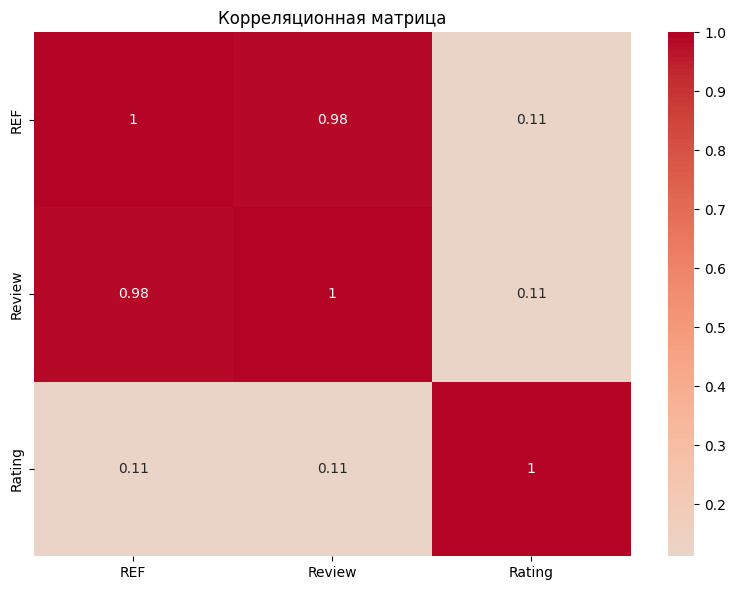

In [7]:
plt.figure(figsize=(8, 6))
correlation_matrix = train_df.select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

**Review или Ref я удалю позже**

Удаляем все строки с пропусками

In [8]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [9]:
y_train = train_df['Rating']
X_train = train_df.drop('Rating', axis=1)

Убираем пустые значения и преобразуем проценты в числовой столбец:

In [10]:
def clean(df):
    _df = df.copy()
    _df['Cocoa Percent_numeric'] = _df['Cocoa Percent'].str.rstrip('%').astype(float)
    _df['Broad Bean Origin_cat'] = _df['Broad Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df['Bean Type_cat'] = _df['Bean Type'].str.split(r'[ ,(]', expand=True)[0].replace('\xa0', np.nan)
    _df['Specific Bean Origin_cat'] = _df['Specific Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    return _df

X_train_cleaned = clean(X_train)

Биннинг процентов:

In [11]:
discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_train_cleaned[['Cocoa Percent_numeric']])

X_train_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_train_cleaned[['Cocoa Percent_numeric']])
X_train_cleaned.drop('Cocoa Percent_numeric', axis=1, inplace=True)

In [12]:
X_train_cleaned['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

In [13]:
XC = X_train_cleaned.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Bean Type_cat,Specific Bean Origin_cat
Company,1.000000,0.999651,0.633931,0.816914,0.653217
Company Location,0.999651,1.000000,0.378944,0.268613,0.735872
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.506266,0.976352
Bean Type_cat,0.816914,0.268613,0.506266,1.000000,0.871187
Specific Bean Origin_cat,0.653217,0.735872,0.976352,0.871187,1.000000


**Признаки Broad Bean Origin_cat и Specific Bean Origin_cat сильно связаны.**

In [14]:
X_train_cleaned.drop('Broad Bean Origin_cat', axis=1, inplace=True)

In [15]:
# Заполняем пропуски

X_train_cleaned['Bean Type_cat'] = X_train_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_train_cleaned['Bean Type_cat'] = X_train_cleaned['Bean Type_cat'].fillna('UNKNOWN')

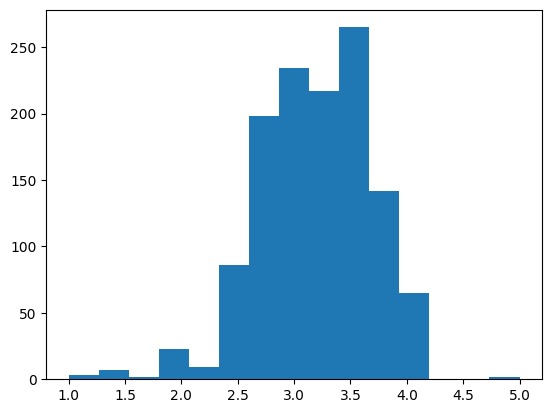

In [16]:
# Распределение целевой переменной
plt.hist(y_train, bins=15);

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [17]:
X_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Bean Type_cat                 1253 non-null   object 
 4   Specific Bean Origin_cat      1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 68.5+ KB


In [18]:
cat_features = [0, 2, 3, 4]
model = CatBoostRegressor(cat_features=cat_features, verbose=False)
model.fit(X_train_cleaned, y_train)

In [19]:
model.score(X_train_cleaned, y_train)

0.5096743166030933

## Предсказание на тестовых данных

Загружаем тестовые данные

In [20]:
test_df = pd.read_csv(TEST)

In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [22]:
X_test_cleaned = clean(test_df)
X_test_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_cleaned[['Cocoa Percent_numeric']])
X_test_cleaned.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [23]:
X_test_cleaned['Bean Type_cat'] = X_test_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_cleaned['Bean Type_cat'] = X_test_cleaned['Bean Type_cat'].fillna('UNKNOWN')

In [24]:
X_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Bean Type_cat                 540 non-null    object 
 4   Specific Bean Origin_cat      540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


Делаем предсказание

In [25]:
pred = model.predict(X_test_cleaned)

Сохраняем предсказание в файл в нужном формате

In [26]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id','Rating']].to_csv("submission.csv", index=False)

Как можно было бы улучшить модель:
- Подбором гипперпараметров
- Попробовать масштабировать признаки